## Use a CNN to discover 2D Gaussian parameters

### Fit gaussian to Laue peaks with CNN (maybe faster) --> to test

### We generate simulated gaussian 2D peaks (with varied sigma), a simple neural netowrk is used (2D convolution network) with regression losses to fit Gaussian center and Gaussian parameters estimation

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import trange
# model summary info
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Create Gaussian blurs with different widths

In [2]:
nGauss  = 1000000
imgSize = 100

# initialize tensors containing images and labels
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,5)

for i in trange(nGauss):
    # location and width parameters
    center_x = np.random.randint(10,imgSize-10)
    center_y = np.random.randint(10,imgSize-10)
    size = np.random.uniform(low=2, high=5)
    sigma_x = np.random.uniform(low=1, high=5)*size
    sigma_y = np.random.uniform(low=1, high=5)*size
    theta = np.random.uniform(low=0,high=45)
    theta = np.deg2rad(theta)
    # rotation
    x = np.arange(0, imgSize, 1, float)
    y = np.arange(0, imgSize, 1, float)
    y = y[:,np.newaxis]
    a=np.cos(theta)*x -np.sin(theta)*y
    b=np.sin(theta)*x +np.cos(theta)*y
    a0=np.cos(theta)*center_x -np.sin(theta)*center_y
    b0=np.sin(theta)*center_x +np.cos(theta)*center_y
    
    # create the gaussian with random centers
    G = np.exp(-(((a-a0)**2)/(2*(sigma_x**2)) + ((b-b0)**2) /(2*(sigma_y**2))))
    G  = G + np.random.randn(imgSize,imgSize)/10
    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:] = torch.Tensor([center_x,center_y,sigma_x,sigma_y,np.rad2deg(theta)] )

100%|██████████| 1000000/1000000 [06:00<00:00, 2777.19it/s]


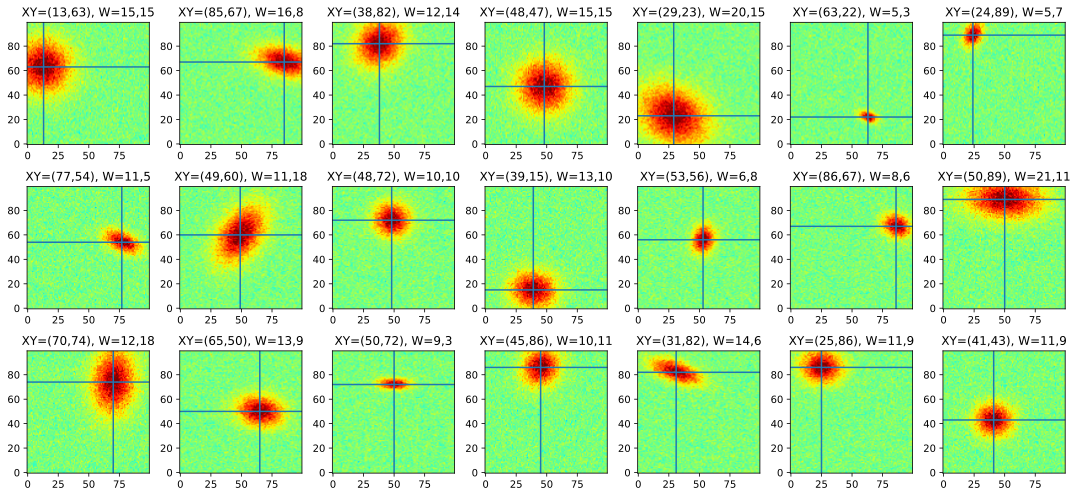

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))
i = 50
for i,ax in enumerate(axs.flatten()):
    np.random.seed(i)
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1,vmax=1,cmap='jet',origin='lower')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f},{labels[whichpic,3]:.0f}')
    ax.axvline(x=labels[whichpic,0])
    ax.axhline(y=labels[whichpic,1])
    i += 1
plt.tight_layout()
plt.show()

# Create train/test groups using DataLoader

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)
# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
# translate into dataloader objects
batchsize    = 5
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([900000, 1, 100, 100])
torch.Size([900000, 5])


# Create the DL model

In [6]:
# create a class for the model
def makeTheNet():
    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()
            # all layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                                      # conv/pool block 1
                                      nn.Conv2d(1,24,3,padding=1),  # output size: (100+2*1-3)/1 + 1 = 100
                                      nn.ReLU(),                   # 
                                      nn.AvgPool2d(2,2),           # output size: 100/2 = 50
                                      # conv/pool block 2
                                      nn.Conv2d(24,48,3,padding=1),  # output size: (50+2*1-3)/1 + 1 = 50
                                      nn.ReLU(),                   # 
                                      nn.AvgPool2d(2,2),           # output size: 50/2 = 25
                                      # linear decision layer
                                      nn.Flatten(),                # vectorize conv2 block output
                                      nn.Linear(25*25*48,200),       # output size: 50
                                      nn.Linear(200,5),             # output size: 4
                                  )
        def forward(self,x):
            return self.enc(x)
    # create the model instance
    net = gausnet()
    # loss function
    lossfun = nn.MSELoss()
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)
    return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()
X,y = iter(train_loader).next()
yHat = net(X)
# check size of output
print(yHat)
print(' ')
print(yHat.shape)
# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[-0.0459, -0.0212, -0.0338, -0.0844,  0.0521],
        [-0.0389, -0.0239, -0.0308, -0.0811,  0.0481],
        [-0.0384, -0.0226, -0.0277, -0.0832,  0.0640],
        [-0.0567, -0.0225, -0.0191, -0.0626,  0.0468],
        [-0.0391, -0.0284, -0.0217, -0.0812,  0.0475]],
       grad_fn=<AddmmBackward0>)
 
torch.Size([5, 5])
 
Loss:
tensor(2140.7117, grad_fn=<MseLossBackward0>)


In [8]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 100, 100]             240
              ReLU-2         [-1, 24, 100, 100]               0
         AvgPool2d-3           [-1, 24, 50, 50]               0
            Conv2d-4           [-1, 48, 50, 50]          10,416
              ReLU-5           [-1, 48, 50, 50]               0
         AvgPool2d-6           [-1, 48, 25, 25]               0
           Flatten-7                [-1, 30000]               0
            Linear-8                  [-1, 200]       6,000,200
            Linear-9                    [-1, 5]           1,005
Total params: 6,011,861
Trainable params: 6,011,861
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 6.41
Params size (MB): 22.93
Estimated Total Size (MB): 29.38
-------------------------------------

# Create a function that trains the model

In [9]:
# a function that trains the model
def function2trainTheModel():
    # number of epochs
    numepochs = 10
    # create a new model
    net,lossfun,optimizer = makeTheNet()
    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    # loop over epochs
    for epochi in trange(numepochs):
        # loop over training data batches
        batchLoss = []
        for X,y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss from this batch
            batchLoss.append(loss.item())
        # end of batch loop...
        # and get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat,y)
        # extract the loss for this test epoch
        testLoss[epochi] = loss.item()
    # end epochs
    # function output
    return trainLoss,testLoss,net

# Run the model and show the results!

In [ ]:
trainLoss,testLoss,net = function2trainTheModel()

  0%|          | 0/10 [00:00<?, ?it/s]

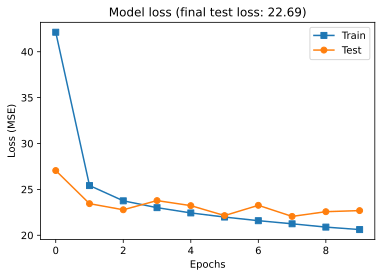

In [38]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])
plt.show()

In [39]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def blockshaped(arr, split_height, split_width, overlap_kernal = 0.0):
    image_set = []
    img_h, img_w = arr.shape[:2]
    X_points = start_points(img_w, split_width, overlap_kernal)
    Y_points = start_points(img_h, split_height, overlap_kernal)
    count = 0
    if len(arr.shape) == 2:
        for i in Y_points:
            for j in X_points:
                split = arr[i:i+split_height, j:j+split_width]
                image_set.append(split)
                count += 1
        return count, np.array(image_set)
    elif len(arr.shape) == 3:
        for i in Y_points:
            for j in X_points:
                split = arr[i:i+split_height, j:j+split_width, :]
                image_set.append(split)
                count += 1
        return count, np.array(image_set)
    
### Load real Laue image
images_raw = plt.imread(r"Ni_laue.tiff")
images_raw = images_raw/1.
##remove background
from lauetoolsnn.lauetools import imageprocessing as ImProc
framedim = images_raw.shape
CCDLabel = 'sCMOS'
backgroundimage = ImProc.compute_autobackground_image(images_raw, boxsizefilter=10)
# basic substraction
images_raw = ImProc.computefilteredimage(images_raw, backgroundimage, 
                                            CCDLabel, usemask=True, formulaexpression="A-B")
#images_raw[0:10, :] = 0
#images_raw[:, 0:10] = 0
# Crop size
imgR, imgC, overlap = 100, 100, 0.05
# All crops
crops_nb, all_crops = blockshaped(images_raw, split_height = imgR, split_width = imgC, overlap_kernal = overlap)

images = torch.zeros(len(all_crops),1,imgR, imgC)
for i, ii in enumerate(all_crops):
    data = ii
    data = data / data.max()
    images[i,:,:,:] = torch.Tensor(data).view(1,imgR, imgC)
    
images = TensorDataset(images)
images.tensors[0].shape


torch.Size([484, 1, 100, 100])

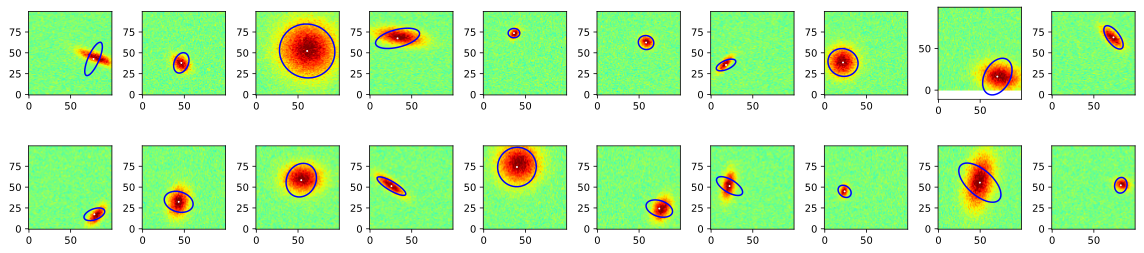

In [42]:
# visualize some images
X,Y = next(iter(test_loader)) # extract X,y from test dataloader
#X = images.tensors[0]

yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):
    # get the Gaussian and draw it, and draw the white guide-lines
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet', origin='lower')
    #ax.imshow(G, cmap='jet', origin='lower')
    # compute the model's prediction
    cx = yHat[i][0].item() # center X
    cy = yHat[i][1].item() # center Y
    rx = 3*yHat[i][2].item() # radius x
    ry = 3*yHat[i][3].item() # radius y
    try:
        ra = np.deg2rad(yHat[i][4].item())
    except:
        ra = 0.0 # rotation angle
    x = cx - (ry * 0.5 * np.sin(th)) * np.sin(ra * np.pi) + (rx * 0.5 * np.cos(th)) * np.cos(ra * np.pi)
    y = cy + (rx * 0.5 * np.cos(th)) * np.sin(ra * np.pi) + (ry * 0.5 * np.sin(th)) * np.cos(ra * np.pi)
    ax.plot(x,y,'b')
    ax.plot(cx,cy,'wo', ms=1)

plt.tight_layout()
plt.show()

In [44]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
paramNames = ['Cx','Cy','radx.','rady.', 'theta']
for i in range(5):
    # extract parameters and compute correlation
    yy = Y[:,i].detach()
    yh = yHat[:,i].detach()
    cr = np.corrcoef(yy,yh)[0,1]
    if i <2:
        # plot with label
        axs[0].plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')
    elif i >3:
        axs[2].plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')
    else:
        axs[1].plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()